Import libraries

In [1]:
import ast
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import requests
from IPython.display import HTML, display
import tabulate
from fuzzywuzzy import fuzz, process
from io import BytesIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import Reader, Dataset,BaselineOnly, SVD, KNNBasic, accuracy

In [2]:
books = pd.read_csv("data//cleaned_books_info.csv", index_col = 0)
books.head()

,average_rating,description,publisher,num_pages,image_url,book_id,ratings_count,title,is_boardbook,WeightedRating,authors_id,title_words,desc_sentnce_count,desc_words,desc_word_count
0,4.15,Fashion goes to the dogs in this lovable follo...,Simon & Schuster Books for Young Readers,48,https://images.gr-assets.com/books/1343249491m...,13037808,942,Zorro Gets an Outfit,0,4.023908,676353,"['Zorro', 'Gets', 'Outfit']",11,"['Fashion', 'goes', 'to', 'the', 'dogs', 'in',...",128
1,3.75,Winter weather is keeping children from visiti...,Knopf Books for Young Readers,40,https://images.gr-assets.com/books/1320544663m...,11080564,471,ZooZical,0,3.996410,1241 25031,['ZooZical'],10,"['Winter', 'weather', 'is', 'keeping', 'childr...",171
2,3.93,The sequel to Gordon Korman's SWINDLE - the Ma...,Scholastic Press,256,https://images.gr-assets.com/books/1328839293m...,6620483,3907,"Zoobreak (Swindle, #2)",0,3.984889,2130,"['Zoobreak', 'Swindle']",5,"['The', 'sequel', 'to', 'Gordon', 'Korman', 'S...",87
3,3.70,How many different ways of walking can you nam...,Blue Apple Books,14,https://s.gr-assets.com/assets/nophoto/book/11...,1644081,22,Zoo Parade!,1,3.919211,6483 90091,"['Zoo', 'Parade']",12,"['How', 'many', 'different', 'ways', 'of', 'wa...",149
4,3.78,Trying to discover the truth about their eerie...,Scholastic Paperbacks,80,https://images.gr-assets.com/books/1360057751m...,312542,701,Zombies Don't Play Soccer (The Adventures of t...,0,3.992553,11639 11644,"['Zombies', ""n't"", 'Play', 'Soccer', 'Adventur...",1,"['Trying', 'to', 'discover', 'the', 'truth', '...",35


The weighted ratings in the books file was estimated in the analysis notebook using the formula, WeightedRating (WR)=(v/(v+m))R+(m/(v+m))C, where R = average rating of the book, v = number of ratings, m = minimum votes required to be listed, C = the mean vote across the whole dataset.

#### All time popular board books

In [3]:
bb_sorted = books.loc[(books.is_boardbook == 1),['title','WeightedRating']].sort_values(by = 'WeightedRating', ascending = False).reset_index(drop = True)
print("\t\t\t\t\t10 Most Popular Boardbooks")
print(tabulate.tabulate(bb_sorted[:10], tablefmt='github', headers = ['Index','Title','Weighted Rating']))

					10 Most Popular Boardbooks
|   Index | Title                                                              |   Weighted Rating |
|---------|--------------------------------------------------------------------|-------------------|
|       0 | Guess How Much I Love You                                          |           4.3582  |
|       1 | The Little Mouse, the Red Ripe Strawberry, and the Big Hungry Bear |           4.30467 |
|       2 | The Very Hungry Caterpillar                                        |           4.28947 |
|       3 | Hairy Maclary from Donaldson's Dairy                               |           4.26675 |
|       4 | Little Blue Truck                                                  |           4.26613 |
|       5 | Barnyard Dance                                                     |           4.24268 |
|       6 | The Best Mouse Cookie                                              |           4.23461 |
|       7 | Each Peach Pear Plum                           

#### All time popular other books

In [4]:
ob_sorted = books.loc[(books.is_boardbook == 0),['title','WeightedRating']].sort_values(by = 'WeightedRating', ascending = False).reset_index(drop = True)
print("\t\t\t\t10 Most Popular Books for Young Readers")
print(tabulate.tabulate(ob_sorted[:10], tablefmt='github', headers = ['Index','Title','Weighted Rating']))

				10 Most Popular Books for Young Readers
|   Index | Title                                                                   |   Weighted Rating |
|---------|-------------------------------------------------------------------------|-------------------|
|       0 | Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)             |           4.52764 |
|       1 | The Monster at the End of this Book                                     |           4.4166  |
|       2 | Wonder (Wonder #1)                                                      |           4.41641 |
|       3 | The Complete Tales and Poems of Winnie-the-Pooh (Winnie-the-Pooh, #1-4) |           4.40143 |
|       4 | Wonder                                                                  |           4.40136 |
|       5 | You Are Special (Wemmicksville, #1)                                     |           4.37533 |
|       6 | The Giving Tree                                                         |           4.36578 |
| 

#### Metadata / Content based Recommender

Recommends by evaluating the similarity between books based on description, title and authors. 

In [5]:
def create_soup(x):
    return ' '.join(ast.literal_eval(x['desc_words']))+' '+' '.join(ast.literal_eval(x['title_words']))+' '+x['authors_id']

In [6]:
books['soup'] = books.apply(create_soup, axis = 1)

In [7]:
print(books.iloc[0]['soup'])

Fashion goes to the dogs in this lovable follow-up to Say Hello to Zorro Mister Bud and Zorro get along just great They wake up together have walk time together and take naps together But something is about to interrupt their schedule Zorro has to wear a fancy outfit Zorro is embarrassed mortified aghast Mr Bud tries to cheer him up but nothing works Everyone makes fun of Zorro and he refuses to participate in chew-on-a-stick time Mister Bud does n't know what to do But when another dog a very cool dog shows up in an outfit and does amazing tricks and beats all the other dogs in a race Zorro discovers that wearing clothes might not be so bad after all Everything is back on schedule Zorro Gets Outfit 676353


In [8]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books['soup'])
tfidf_matrix.shape

(5937, 30867)

Cosine Similarity is used to measure the similarity between the book vectors

In [9]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [10]:
indices = pd.Series(books.index, index=books['title'].str.lower())

In [11]:
def content_recommender(user_input, df=books, indices=indices):
    
    
    if user_input.lower() not in indices:
        print(f"User Input: ", user_input)
        Ratio = dict()
        for title in indices.index:
            Ratio[title] = fuzz.token_set_ratio(user_input.lower(), title)
        Ratio_sorted = sorted(Ratio.items(), key=lambda item: item[1], reverse=True)
        closest_title = Ratio_sorted[0][0]
        content_recommender(closest_title)    
    else:
        print(f"Title Matched: ",string.capwords(user_input))
        idx = indices[user_input.lower()]
        
    # pairwise similarity scores of all books with the book entered. Output as list of tuples.
        sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort books based on the cosine similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # select 10 most similar books. Ignore the first book.
        sim_scores = sim_scores[1:11]
        book_indices = [i[0] for i in sim_scores]
    # Top 10 book recommendations
        top = df[['title','WeightedRating','average_rating','num_pages', 'image_url', 'is_boardbook']].iloc[book_indices]
    # Read the top 10 recommended book urls and print the images
        for i in top['image_url']:
            if i[31:38] != 'nophoto':
                response = requests.get(i)
                img = Image.open(BytesIO(response.content))
                plt.figure()
                plt.axis('off')
                print(plt.imshow(img))
        print("\t\t\tThe Top 10 Recommended Books using Content Recommender")
        print(tabulate.tabulate(top[['title','average_rating']].reset_index(drop = True), tablefmt='github', headers = ['Index','Title','Average Rating']))
    return None

User Input:  lion king
Title Matched:  Disney's The Lion King
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
			The Top 10 Recommended Books using Content Recommender
|   Index | Title                                                             |   Average Rating |
|---------|-------------------------------------------------------------------|------------------|
|       0 | The Three Little Pigs                                             |             4.2  |
|       1 | James and the Giant Peach                                         |             3.99 |
|       2 | James & The Giant Peach                                           |             3.99 |
|       3 | The Story of the Little Mole Who Went in Search of Whodunit       |             4.16 |
|       4 | Pocahontas                                                        |             4.48 |
|      

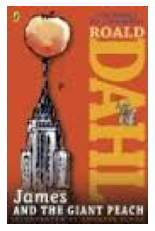

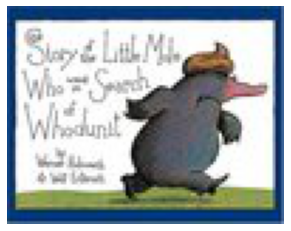

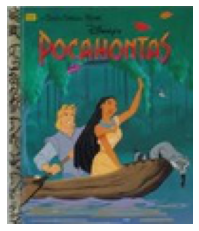

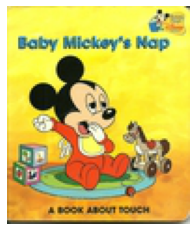

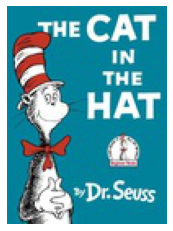

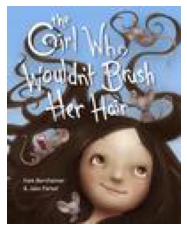

In [12]:
content_recommender('lion king')

#### Collaborative Filtering

In [13]:
ratings = pd.read_csv("data//cleaned_user_ratings_info.csv",index_col = 0)
ratings.head()

,user_id,book_id,review_id,rating,date_updated,n_users_rated,n_books_rated
0,d1e368a7d2870eb6fbf6e0d350568a2d,23310161,87fb7685b0b1aa774cc14c330bdcfadf,4,Mon Aug 31 07:07:40 -0700 2015,1481,343
1,d1e368a7d2870eb6fbf6e0d350568a2d,1969280,3f21c462c88b57186b6f0c2becc121e2,3,Wed Sep 28 17:03:19 -0700 2016,462,343
2,d1e368a7d2870eb6fbf6e0d350568a2d,17290220,0a07041c829634236433f24409860be8,4,Wed Sep 28 16:45:23 -0700 2016,842,343
3,d1e368a7d2870eb6fbf6e0d350568a2d,231850,f1ed8ca9c5abfe0286f00b97d4d3965a,4,Tue Jan 05 19:13:00 -0800 2010,10215,343
4,d1e368a7d2870eb6fbf6e0d350568a2d,4948,285df57ea41be7f41d5a404d2ffad03a,5,Fri Jul 25 11:00:09 -0700 2014,18497,343


In [14]:
ratings.drop(columns = ['review_id','date_updated','n_users_rated', 'n_books_rated'], inplace = True)

In [15]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)

Baseline Model

In [16]:
baseline_clf = BaselineOnly()
cross_validate(baseline_clf, data, measures=['RMSE'], cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7680  0.7704  0.7685  0.7670  0.7697  0.7687  0.0012  
Fit time          3.84    4.28    4.34    4.36    4.35    4.23    0.20    
Test time         1.91    2.00    1.83    1.85    1.71    1.86    0.10    


{'test_rmse': array([0.76796907, 0.77035509, 0.76848115, 0.76697636, 0.76966112]),
 'fit_time': (3.844409704208374,
  4.280689716339111,
  4.336125135421753,
  4.357484579086304,
  4.3493475914001465),
 'test_time': (1.9055054187774658,
  2.0037598609924316,
  1.8298084735870361,
  1.852051019668579,
  1.7134451866149902)}

Matrix Factorization based algorithm - Singular Value Decomposition model

In [17]:
#Tuning the SVDpp algorithm is very intensive process to perform with this laptop
#train test split and gridsearch cv for parameter tuning
trainset, testset = train_test_split(data, test_size=0.1)
param_grid = {'n_epochs': [16,18], 'lr_all': [0.006, 0.007]} #,"reg_all": [0.4, 0.6]
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.7637713765085558
{'n_epochs': 18, 'lr_all': 0.006}


In [18]:
algo = gs.best_estimator['rmse']
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.7522


0.7521998219503164

Predictions from the collaborative filtering model

In [19]:
pred = pd.DataFrame(predictions).reset_index(drop = True)
pred.drop(columns = ['details'], inplace = True)
pred.columns = ['User Id','Book Id','Actual Rating','Predicted Rating' ]
pred[pred['User Id'] == '9502d011ea04f6bb61e94ceb6e8de509']

,User Id,Book Id,Actual Rating,Predicted Rating
1048,9502d011ea04f6bb61e94ceb6e8de509,782854,4.0,3.947358
17962,9502d011ea04f6bb61e94ceb6e8de509,24155,3.0,3.568208
43059,9502d011ea04f6bb61e94ceb6e8de509,902357,4.0,3.470348
67084,9502d011ea04f6bb61e94ceb6e8de509,42407,5.0,3.718588
96886,9502d011ea04f6bb61e94ceb6e8de509,857448,5.0,3.880226
105179,9502d011ea04f6bb61e94ceb6e8de509,631146,3.0,3.479746


In [20]:
svd_tuned = SVD(n_epochs = 18, lr_all = 0.006)
cross_validate(svd_tuned, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7546  0.7586  0.7538  0.7579  0.7565  0.7563  0.0018  
Fit time          60.62   61.74   60.94   61.86   61.53   61.34   0.48    
Test time         2.91    3.21    2.81    3.02    2.72    2.93    0.17    


{'test_rmse': array([0.75464628, 0.75857506, 0.7537801 , 0.75793608, 0.7565352 ]),
 'fit_time': (60.624993562698364,
  61.74324417114258,
  60.93766784667969,
  61.855565547943115,
  61.526665687561035),
 'test_time': (2.907569408416748,
  3.211416006088257,
  2.808126449584961,
  3.0239551067352295,
  2.7157421112060547)}

The root mean square error value improved by 0.0124 using the singular value decomposition model.

#### Hybrid Recommender

Using content recommender to find similar books based on the title, description and authors. Then using collaborative filtering to evaluate ratings of those books for the given user. Presenting the top 10 based on predicted rating.

In [23]:
def hybrid(userId = None, title_input = None):
    
    if title_input.lower() not in indices:
        Ratio = dict()
        for title in indices.index:
            Ratio[title] = fuzz.token_set_ratio(title_input.lower(), title)
        Ratio_sorted = sorted(Ratio.items(), key=lambda item: item[1], reverse=True)
        closest_title = Ratio_sorted[0][0]
        content_recommender(closest_title)    
    else:
        idx = indices[title_input.lower()]
        print(f"Title Matched: ",title_input)
    # pairwsie similarity scores of all books with the book entered. Output as list of tuples.
        sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort books based on the cosine similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # 10 most similar books. Ignoring the first book.
        sim_scores = sim_scores[1:26]
        book_indices = [i[0] for i in sim_scores]
    # Top 10 book recommendations
        top = books[['book_id','ratings_count','average_rating','num_pages','publisher','title','WeightedRating' ,'image_url']].iloc[book_indices]
    #the predicted rating using SVD
        top['predicted_rating'] = top['book_id'].apply(lambda x: svd_tuned.predict(userId, x).est)
    #Sort books in decreasing order of predicted rating
        top = top.sort_values('predicted_rating', ascending=False).reset_index(drop = True).head(10)
    # Read the top 10 recommended book urls and print the images
        for i in top['image_url'][:10]:
            if i[31:38] != 'nophoto':
                response = requests.get(i)
                img = Image.open(BytesIO(response.content))
                plt.figure()
                plt.axis('off')
                print(plt.imshow(img))
        print("\t\t\tThe Top 10 Recommended Books using Hybrid Recommender")
        print(tabulate.tabulate(top[['title','publisher']].reset_index(drop = True), tablefmt='github', headers = ['Index','Title','Publisher']))
    return None

Title Matched:  The Lion and the Mouse
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
			The Top 10 Recommended Books using Hybrid Recommender
|   Index | Title                                                     | Publisher            |
|---------|-----------------------------------------------------------|----------------------|
|       0 | Armstrong: The Adventurous Journey of a Mouse to the Moon | NorthSouth Books     |
|       1 | Lindbergh: The Tale of a Flying Mouse                     | NorthSouth Books     |
|       2 | The Lion Inside                                           | Orchard Books        |
|       3 | Lion vs. Rabbit                                           | Peachtree Publishers |
|       4 | Aesop's Illustrated Fables                                | Barnes & Noble Inc   |
|       5 | A Lion in the Mea

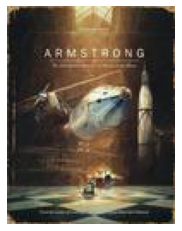

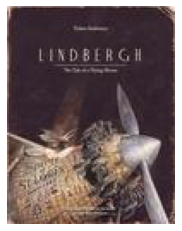

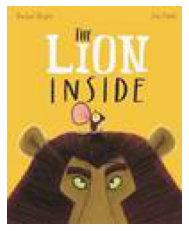

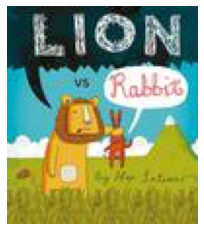

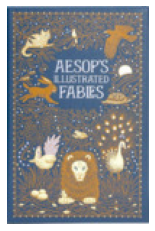

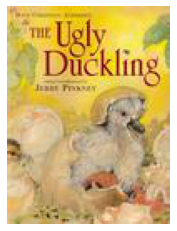

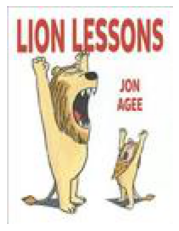

In [24]:
hybrid(userId = '906e8375407cdbeb743d86e66f1aebb2', title_input = "The Lion and the Mouse")